In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from plotnine import *
import itertools
from nilearn import image, plotting, datasets, masking
import nibabel as nib
import pdb
import os
from nilearn.datasets import load_mni152_brain_mask, load_mni152_template

In [2]:
study='hemispace'

patient_dir = f"/lab_data/behrmannlab/vlad/{study}"

control_dir = f"/lab_data/behrmannlab/vlad/hemispace"
suf = '_roi'
exps = ['spaceloc','toolloc']
exps = ['spaceloc','toolloc','loc', 'loc']
copes = [1,1,1,4]
cond = ['space', 'tool','face','word']
p_hemi = ['right', 'left','right'] #the remaining hemi of the sub
c_hemi = ['left', 'right']

c_subs =["spaceloc1001", "spaceloc1002", "spaceloc1003", "spaceloc1004", "spaceloc1005", "spaceloc1006", "spaceloc1007",
"spaceloc1008" ,"spaceloc1009", "spaceloc1010", "spaceloc1011" ,"spaceloc1012",
"spaceloc2013","spaceloc2014","spaceloc2015","spaceloc2016" ]

c_subs =["hemispace2001", "hemispace2002", "hemispace2003"]

p_subs = ['hemispace1001','hemispace1002','hemispace1003']

file_suf  = '_raw'

#left is negative, right is positive
mni = load_mni152_brain_mask()
mni_affine = mni.affine

In [4]:
import seaborn as sns, matplotlib.pyplot as plt
sns.set(style="whitegrid")

region = ['dorsal', 'dorsal', "ventral", 'ventral']
cond = ['space', 'tool', 'face', 'word' ]
for ee in enumerate(cond):
    control_df = pd.read_csv(f'results/control_{region[ee[0]]}_summary{file_suf}.csv')
    patient_df = pd.read_csv(f'results/patient_{region[ee[0]]}_summary{file_suf}.csv')

    full_df = control_df.append(patient_df)
    print(ee)
    task_df = full_df[full_df['task'] == ee[1]]

    sns.barplot(x="hemi", y="selec_spread",hue = "group", data=task_df, ci=95, alpha= .5).set(title= ee[1])
    sns.swarmplot(x="hemi", y="selec_spread", hue = "group", data=task_df,edgecolor = '0', size =10, dodge = True)
    plt.ylabel("Summed Selectivity")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()

    plt.savefig(f"figures/{ee[1]}_{region[ee[0]]}_summed_selec{file_suf}.png")
    
    plt.pause(0.001)
    plt.close()

(0, 'spaceloc')


ValueError: min() arg is an empty sequence

reloaded anat mask left 1 [88, 128, 128]
zero for left
made half mask left 1


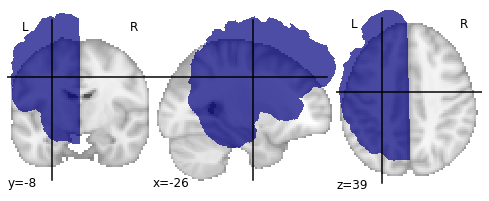

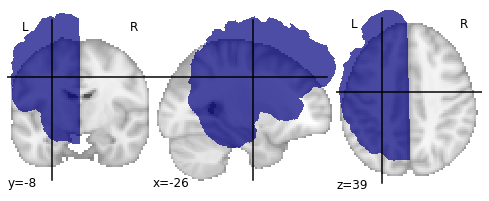

reloaded anat mask right 1 [88, 128, 128]
zero for right
made half mask right 1


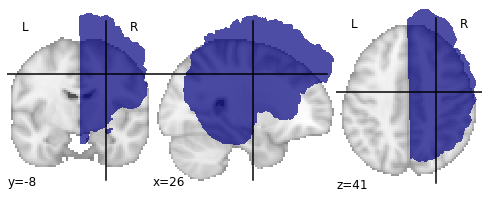

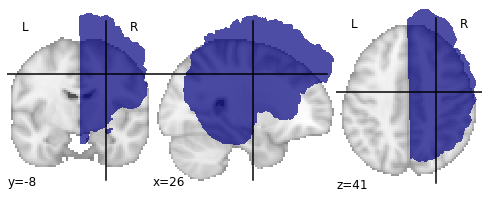

In [42]:
sub = [0, 'hemispace2001']
study_dir = control_dir
sub_dir = f'{study_dir}/sub-{sub[1]}/ses-01/'
#stat_dir = f'{sub_dir}/fsl/{exp[1]}/HighLevel{suf}.gfeat/cope{copes[exp[0]]}.feat/'

#load anat
anat_mask = image.load_img(f'{sub_dir}/anat/sub-{sub[1]}_ses-01_T1w_brain_mask.nii.gz')
affine = anat_mask.affine


for hemi in ['left','right']:
    anat_mask = image.load_img(f'{sub_dir}/anat/sub-{sub[1]}_ses-01_T1w_brain_mask.nii.gz')
    affine = anat_mask.affine
    hemi_mask = image.get_data(anat_mask)
    
    #extract just one hemi
    mid = list((np.array((hemi_mask.shape))/2).astype(int)) #find mid point of image
    print('reloaded anat mask', hemi, np.max(hemi_mask), mid)

    hemi_mask[hemi_mask>0] = 1 #ensure to mask all of it

    if hemi == 'left':
        hemi_mask[mid[0]:, :, :] = 0 
        print('zero for left')
    else:
        hemi_mask[:mid[0], :, :] = 0 
        print('zero for right')

    print('made half mask',hemi, np.max(hemi_mask))
    hemi_mask = nib.Nifti1Image(hemi_mask, affine)  # create a mask for just that hemi image
    
    plotting.plot_roi(hemi_mask)
    plt.pause(.001)
    plotting.plot_roi(anat_mask)
    plt.pause(.001)

/lab_data/behrmannlab/vlad/hemispace/sub-hemispace2001/ses-01/anat/sub-hemispace2001_ses-01_T1w_brain_mask_right.nii.gz


/home/vayzenbe/.local/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:68: UserWarning: The given float value must not exceed 0. But, you have given threshold=1e-06 
/home/vayzenbe/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
/home/vayzenbe/.local/lib/python3.8/site-packages/nilearn/plotting/find_cuts.py:61: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.



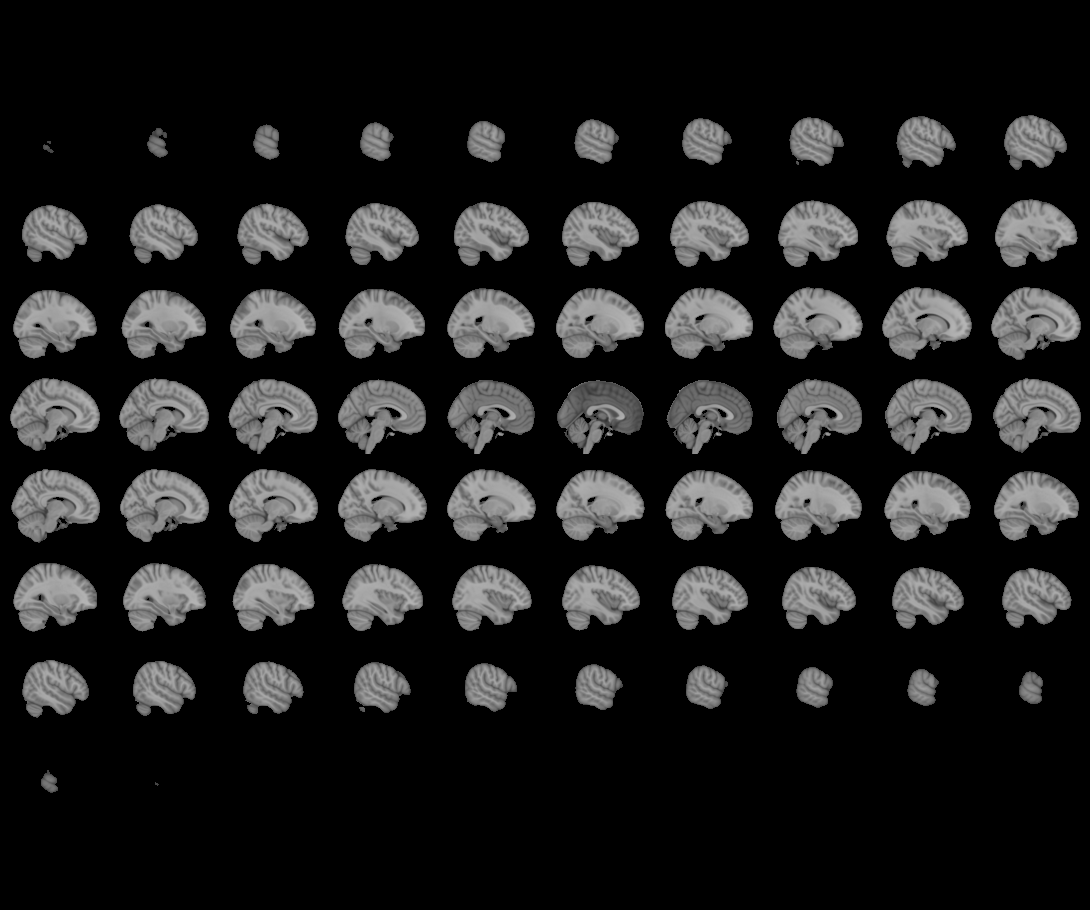
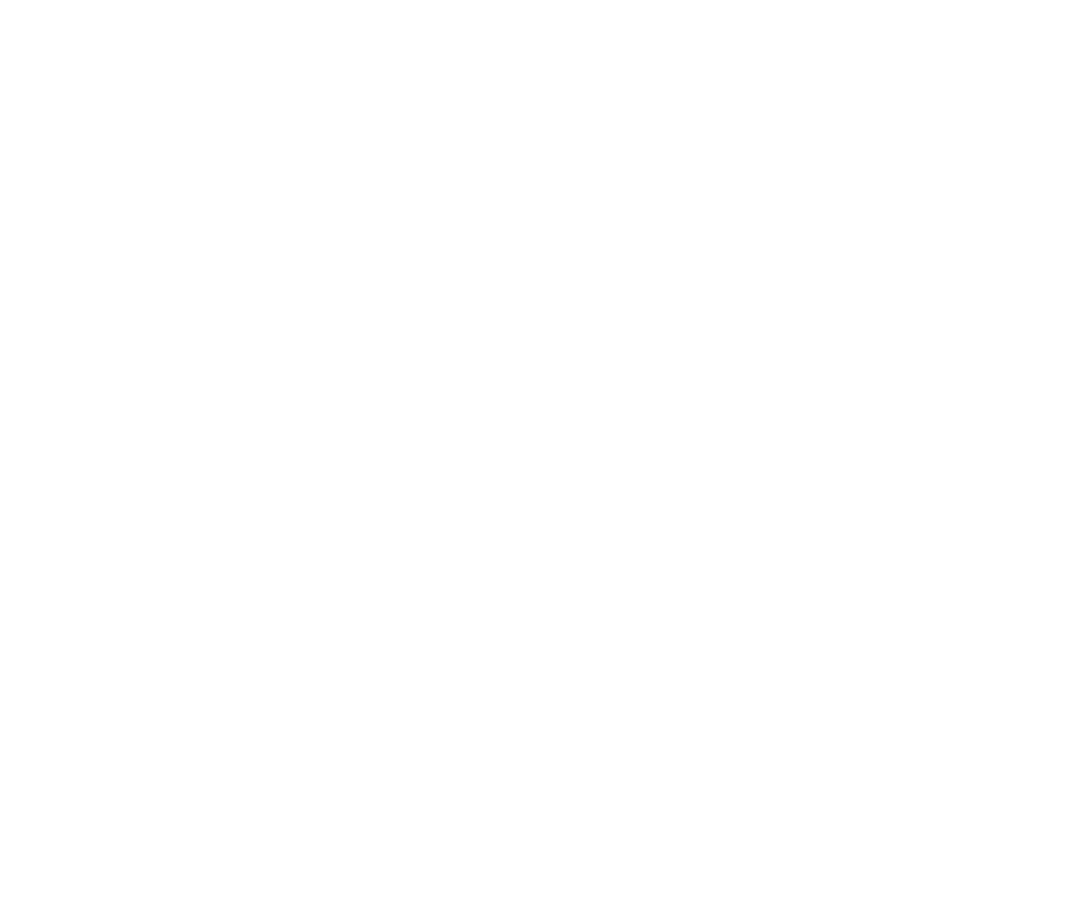

In [37]:
print(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask_{hemi}.nii.gz')
plotting.view_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask_{hemi}.nii.gz')

hemispace2001 left


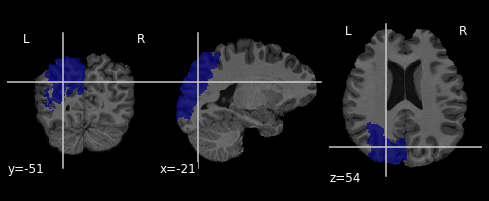

hemispace2001 right


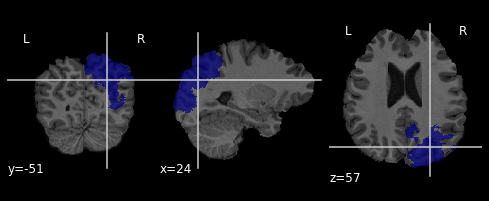

hemispace2002 left


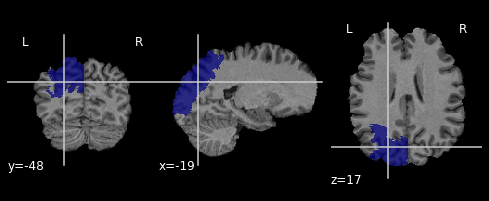

hemispace2002 right


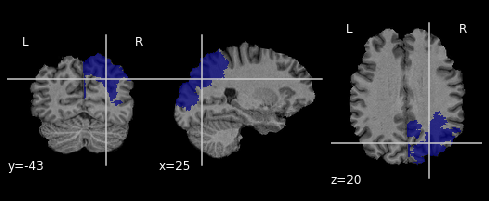

hemispace2003 left


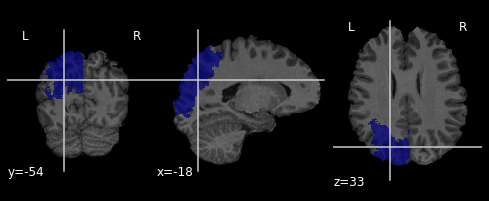

hemispace2003 right


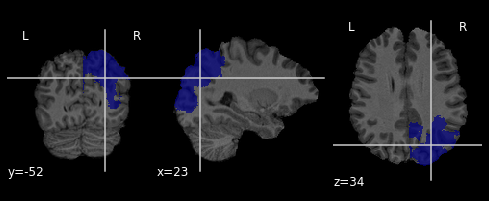

In [45]:
#p_subs = ['hemispace1001']
'''visualize ROIs on controls'''
for ss in enumerate(c_subs):
    for hemi in ['left','right']:
        parcel = combine_dorsal(ss[1],parcels)
        
        print(ss[1], hemi)

        anat = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain.nii.gz')
        anat_mask = image.get_data(image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask_{hemi}.nii.gz'))
        affine = anat.affine

        parcel = anat_mask * parcel

        roi = nib.Nifti1Image(parcel, affine)
        #roi = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/rois/parcels/{rois[ss[0]]}.nii.gz'
        plotting.plot_roi(roi, bg_img=anat)
        plt.pause(.001)

(0, 'hemispace1001')


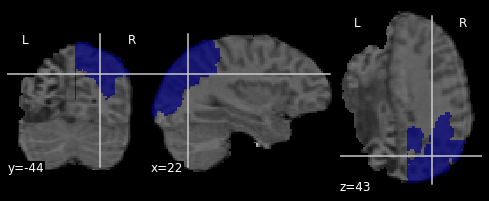

(1, 'hemispace1002')


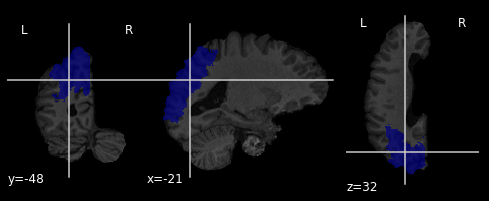

(2, 'hemispace1003')


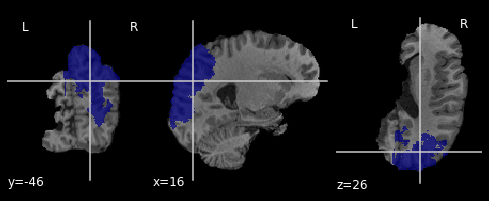

In [46]:
#p_subs = ['hemispace1001']
'''visualize ROIs on patient'''
for ss in enumerate(p_subs):
    parcel = combine_dorsal(ss[1],parcels)
    
    print(ss)

    anat = image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain.nii.gz')
    anat_mask = image.get_data(image.load_img(f'{patient_dir}/sub-{ss[1]}/ses-01/anat/sub-{ss[1]}_ses-01_T1w_brain_mask_{p_hemi[ss[0]]}.nii.gz'))
    affine = anat.affine

    parcel = anat_mask * parcel

    roi = nib.Nifti1Image(parcel, affine)
    #roi = f'{patient_dir}/sub-{ss[1]}/ses-01/derivatives/rois/parcels/{rois[ss[0]]}.nii.gz'
    plotting.plot_roi(roi, bg_img=anat)
    plt.pause(.001)

face


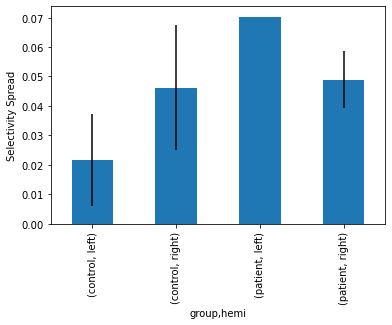

word


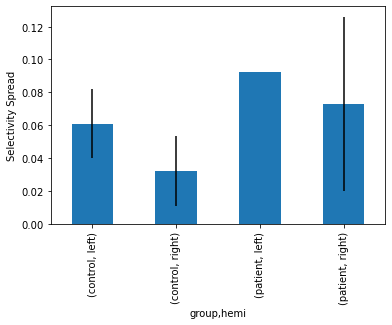

In [8]:
'''
plot bar graphs for patient vs. controls
'''

region = "ventral"

for ee in cond:
    control_df = pd.read_csv(f'control_{region}_summary.csv')
    patient_df = pd.read_csv(f'patient_{region}_summary.csv')

    full_df = control_df.append(patient_df)
    print(ee)
    task_df = full_df[full_df['task'] == ee]
    means = task_df.groupby(by= ['group','hemi']).mean()

    error = task_df.groupby(by= ['group','hemi']).sem()
    means.plot(kind = 'bar', yerr= error, legend = False, ylabel = 'Selectivity Spread')
    plt.pause(.001)

In [33]:
task_df

,subj,group,task,hemi,selec_spread


spaceloc


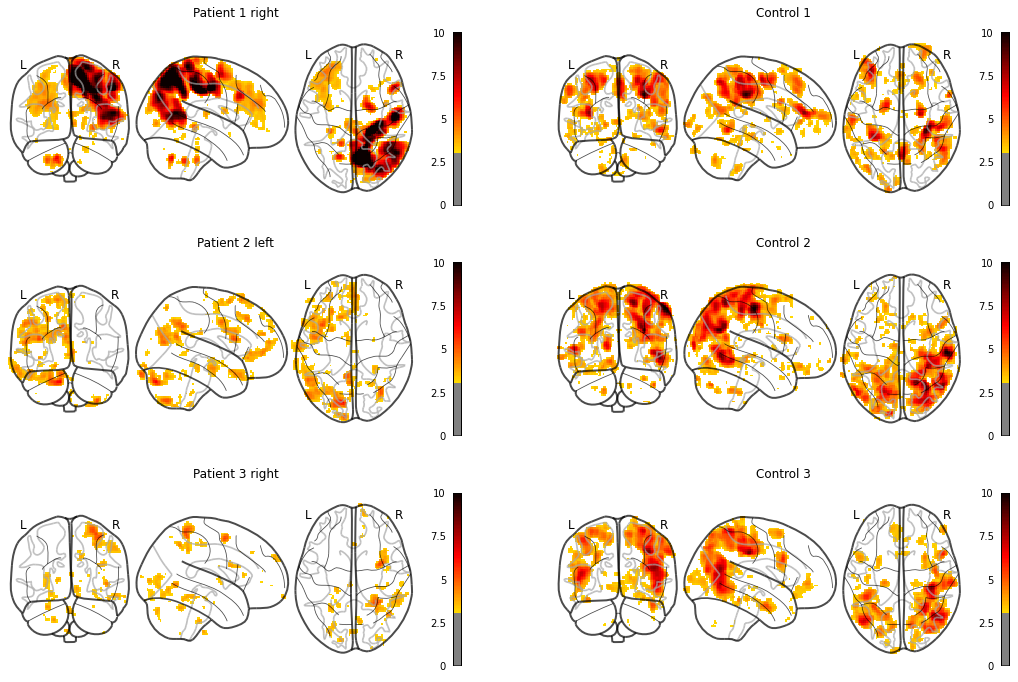

toolloc


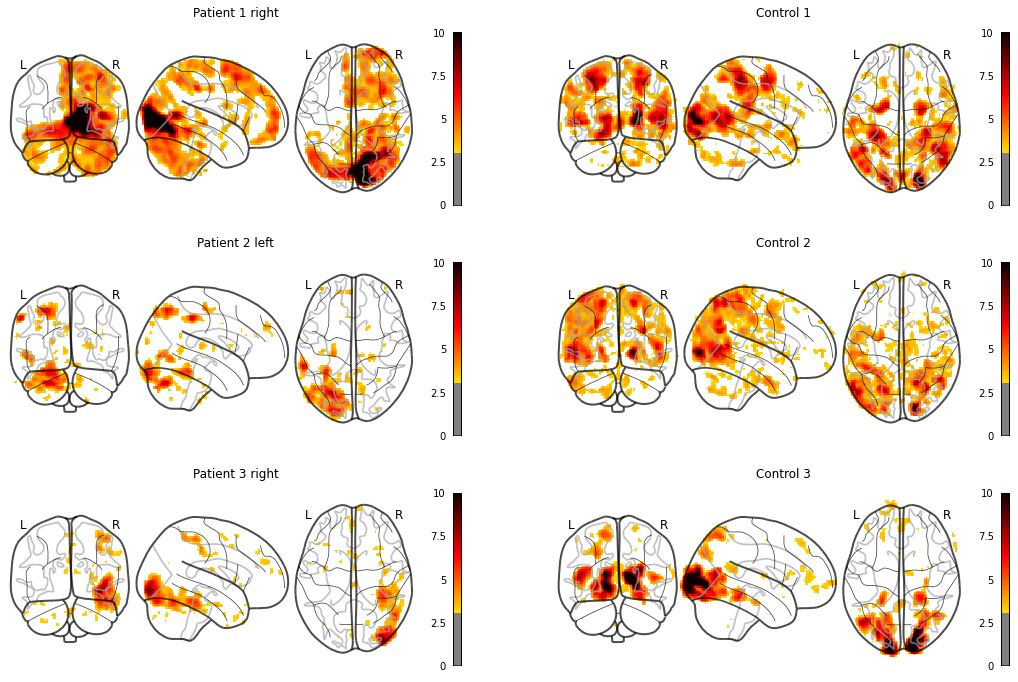

In [88]:

for ee in exps:
    fig, axes = plt.subplots(nrows=len(p_subs), ncols=2, figsize=(18, 12))
    print(ee)
    for axn in range(0,axes.shape[0]):
        #plot patient on lefthand side
        p_dir = f'{control_dir}/sub-{p_subs[axn]}/ses-01/derivatives/'
        p_stat = image.load_img(f'{p_dir}/fsl/{ee}/HighLevel{suf}.gfeat/cope1.feat/stats/zstat1_reg.nii.gz')
        p_stat = image.resample_to_img(p_stat, mni)
        display = plotting.plot_glass_brain(p_stat, axes=axes[axn,0], threshold = 3.1, draw_cross = False, colorbar = True, vmin = 3.1,vmax = 10)
        axes[axn,0].title.set_text(f'Patient {axn + 1} {p_hemi[axn]}')

        #plot control on righthand side
        c_dir = f'{control_dir}/sub-{c_subs[axn]}/ses-01/derivatives/'
        c_stat = image.load_img(f'{c_dir}/fsl/{ee}/HighLevel{suf}.gfeat/cope1.feat/stats/zstat1_reg.nii.gz')
        display = plotting.plot_glass_brain(c_stat, axes=axes[axn,1], threshold = 3.1, draw_cross = False, colorbar = True, vmin = 3.1,vmax = 10)
        axes[axn,1].title.set_text(f'Control {axn + 1}')

    plt.show()
    plt.pause(0.001)

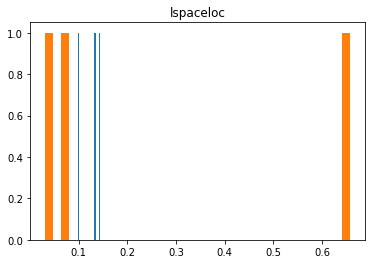

lspaceloc


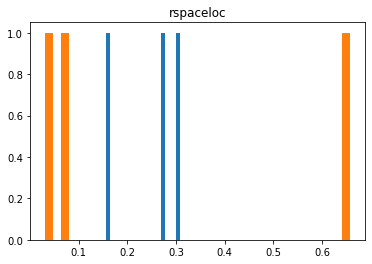

rspaceloc


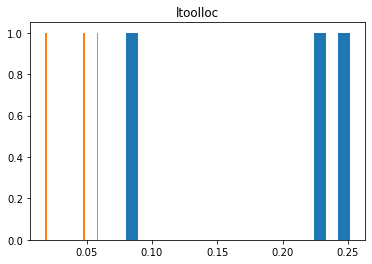

ltoolloc


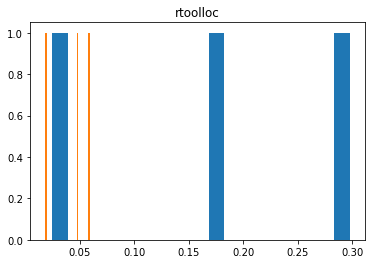

rtoolloc


In [27]:
for exp in exps:
    for lr in ['l','r']:
        plt.title(f'{lr}{exp}')
        plt.hist(control_summary[f'{lr}{exp}'], rwidth = .5)
        plt.hist(patient_summary[exp], 20, rwidth = .5)
        plt.pause(0.0001)
        print(f'{lr}{exp}')
        

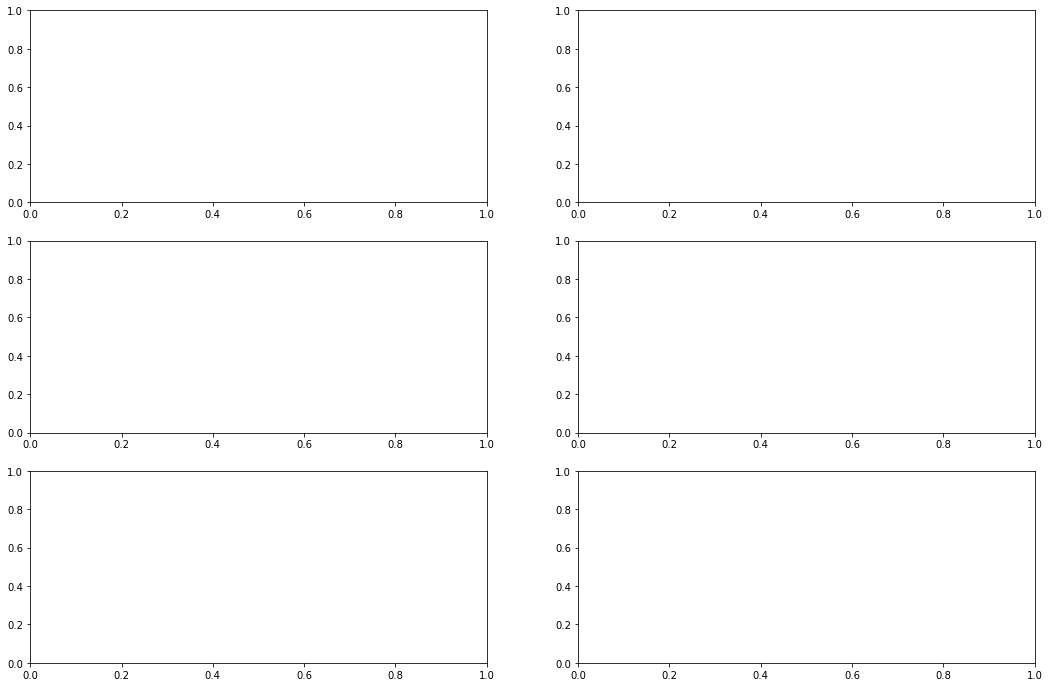

In [32]:
fig, axes = plt.subplots(nrows=len(p_subs), ncols=2, figsize=(18, 12))

In [34]:
axes.shape[0]

3

In [253]:
df_summary.mean()

lspaceloc    0.272156
ltoolloc     0.059526
rspaceloc    0.167944
rtoolloc     0.060327
dtype: float64

In [94]:
f'{stat_dir}/stats/zstat1.nii.gz'

'/lab_data/behrmannlab/vlad/hemispace/sub-hemispace1001/ses-01/derivatives//fsl/toolloc/HighLevel_roi.gfeat/cope1.feat//stats/zstat1.nii.gz'

In [62]:
anat_np = image.get_data(anat)
mid = list((np.array((anat_np.shape))/2).astype(int))
anat_np[anat_np>0] = 1
anat_np[mid[0]:, :, :] = 0 
rh_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image
print(mid)

[64, 80, 80]


In [71]:
anat_np[anat_np>0] = 1
anat_np[mid[0]:, :, :] = 0 
rh_mask = nib.Nifti1Image(anat_np, affine)  # create the volume image


In [ ]:
hemi_mask

In [77]:
anat_np = image.get_data(anat)
anat_test = nib.Nifti1Image(anat_np, affine)  # create the volume image